## 1.  Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn import tree
import seaborn as sn
import pickle
import shap

## 2. Analysis without text features

In [2]:
#Prepare dataset 
df = pd.read_parquet("./SINTEXTO.parquet").reset_index(drop=True)
df.drop(columns=['Text', 'Title'], inplace=True)
df['Publication'] = df['Publication'].astype('category')
df.describe()

,Claps,Reading_Time,Images,Links,Code_Chunks,Numbered_Lists,Bullet_Lists,Bolded,Italics,Days_since_publication,...,Label_Machine Learning,Label_Computer Vision,Label_Data Visualization,Label_Bitcoin,Label_Blockchain,Label_Docker,Label_Python,Label_TensorFlow,Label_Data,Label_Cryptocurrency
count,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,...,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000
mean,140.025057,6.606153,7.254990,6.714568,3.040027,0.566916,3.341829,29.600840,31.981584,261.879954,...,0.452578,0.027032,0.048069,0.019385,0.026673,0.012529,0.174253,0.023980,0.492820,0.024914
std,144.325256,3.535831,7.563552,8.986468,6.127053,1.206327,2.939021,57.551885,75.026887,210.522335,...,0.497755,0.162179,0.213915,0.137878,0.161128,0.111230,0.379334,0.152991,0.499957,0.155865
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,4.000000,2.000000,2.000000,0.000000,0.000000,2.000000,1.000000,0.000000,94.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,90.000000,6.000000,5.000000,4.000000,0.000000,0.000000,2.000000,10.000000,6.000000,206.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,204.000000,8.000000,10.000000,9.000000,4.000000,1.000000,4.000000,34.000000,35.000000,387.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,636.000000,71.000000,198.000000,475.000000,135.000000,37.000000,72.000000,2521.000000,2493.000000,1867.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
#Obtain classes 
q = df['Claps'].quantile(0.5) 
df['claps_RANGE'] = df['Claps']
df['claps_RANGE'] = df['claps_RANGE'].apply(lambda claps: {claps>=q:0, claps<=q:1}.get(True))
df['claps_RANGE'].value_counts()

1    13937
0    13919
Name: claps_RANGE, dtype: int64

In [4]:
#Train/Test
FEATURES = list(df.drop(columns=['Claps','claps_RANGE']).columns)
TARGET = 'claps_RANGE'
X = df[FEATURES]
y = df['claps_RANGE']
df_train, df_test = train_test_split(df, test_size=0.2)

In [5]:
#Create Model
model = LGBMClassifier(n_estimators=1000, max_depth=7, objective='binary')
model.fit(X=df_train[FEATURES], y=df_train[TARGET])
y_true = df_test[TARGET]
y_scores = model.predict_proba(df_test[FEATURES]) 
print('AUC: ', metrics.roc_auc_score(y_true.values, y_scores[:,1]))

AUC:  0.7661974847526403


Confusion Matrix: 


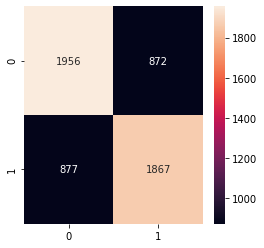

In [9]:
print ('Confusion Matrix: ')
df_cm = pd.DataFrame(metrics.confusion_matrix(y_true, model.predict_proba(df_test[FEATURES])[:,1] > 0.5))
plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True, fmt='d')

In [10]:
print ('Report : ')
print (metrics.classification_report(y_true, model.predict(df_test[FEATURES])))

Report : 
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      2828
           1       0.68      0.68      0.68      2744

    accuracy                           0.69      5572
   macro avg       0.69      0.69      0.69      5572
weighted avg       0.69      0.69      0.69      5572



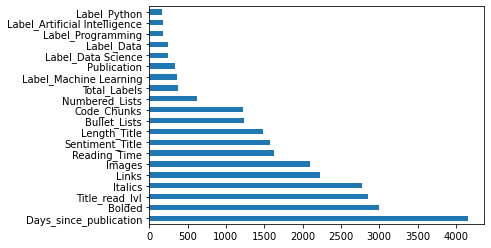

In [11]:
# Features Importance 
pd.Series(data = model.feature_importances_, index = df_train[FEATURES].columns).nlargest(20).plot.barh()

In [9]:
# save the model to disk
filename = 'model_NoText.sav'
pickle.dump(model, open(filename, 'wb'))